In [18]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import pandas as pd


def seq2onehot(seq):     #convert the cRBS sequences to one-hot encoding
    module = np.array([[[1,0,0,0]],
                       [[0,1,0,0]],
                       [[0,0,1,0]],
                       [[0,0,0,1]]])
    i = 0
    cRBS_onehot = []
    for i in seq:
        tmp = []
        for item in i:
            if item == 't' or item == 'T':
                tmp.append(module[0])
            elif item == 'c' or item == 'C':
                tmp.append(module[1])
            elif item == 'g' or item == 'G':
                tmp.append(module[2])
            elif item == 'a' or item == 'A':
                tmp.append(module[3])
            else:
                tmp.append([[0,0,0,0]])
        cRBS_onehot.append(tmp)
    cRBS_onehot=np.array(cRBS_onehot).astype('float32')
    return cRBS_onehot


In [19]:

# x_train=np.load("data/c.v 0.8_p.npy",allow_pickle=True)
x_train=pd.read_excel('data/promoter_w_20799.xlsx',header=None).to_numpy().reshape(-1)
x_train=seq2onehot(x_train)
# y_train=np.array(list(map(float,np.load("data/c.v 0.8_s.npy",allow_pickle=True))))
y_train=pd.read_excel('data/fluorescence_w_20799.xlsx',header=None).to_numpy().reshape(-1)
# y_train_new=np.zeros((len(y_train),))
# i=0
# while i < len(y_train):
#     y_train_new[i]=float(y_train[i])
#     i=i+1
# y_train=np.log2(y_train_new)
# y_train 归一化
y_train=(y_train-np.min(y_train))/(np.max(y_train)-np.min(y_train))


0it [05:23, ?it/s]


/tmp/ipykernel_175973/3962096465.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train)


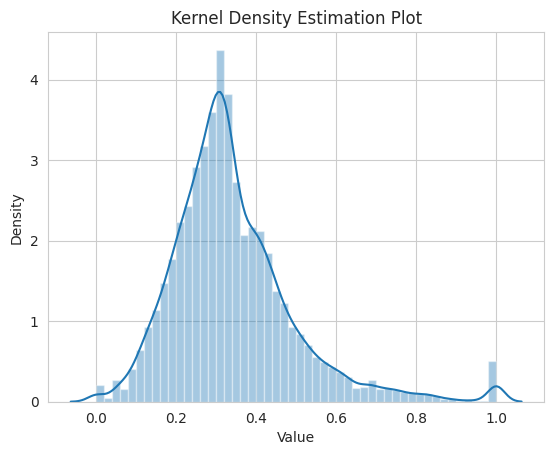

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
sns.distplot(y_train)
plt.title('Kernel Density Estimation Plot')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()
# 绘制直方图


In [21]:
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from keras.layers.core import Activation
from keras.layers import LeakyReLU,BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers.legacy import SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Average
# optimizer = SGD(lr=0.001, decay=1e-6)
# model = Sequential()

# model.add(
#         #(6,1,4)
#         Conv2D(100, (6, 1),
#         padding='same',
#         input_shape=(29, 1, 4))
#         )
# model.add(LeakyReLU(alpha=0.1))
# model.add(MaxPooling2D(pool_size=(2, 1)))
# model.add(Conv2D(200, (5, 1),padding='same'))
# model.add(LeakyReLU(alpha=0.1))
# model.add(Conv2D(200, (5, 1),padding='same'))
# model.add(LeakyReLU(alpha=0.1))
# model.add(MaxPooling2D(pool_size=(2, 1)))
# model.add(Flatten())
# model.add(Dense(1024))
# model.add(LeakyReLU(alpha=0.1))
# model.add(Dropout(0.3))
# model.add(Dense(1))
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv2D(100,  (6,1), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2,1)))
    model.add(Conv2D(200, (5,1), activation='relu'))
    model.add(MaxPooling2D((2,1)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))  # 输出层，使用线性激活函数
    return model
input_layer = Input(shape=(29, 1, 4))
num_models = 5
cnn_models = [create_cnn_model((29, 1, 4))(input_layer) for _ in range(num_models)]
merged = Average()(cnn_models)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=42)
ensemble_model = Model(inputs=input_layer, outputs=merged)
ensemble_model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mae'])
ensemble_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 29, 1, 4)]   0           []                               
                                                                                                  
 sequential_10 (Sequential)     (None, 1)            215597      ['input_3[0][0]']                
                                                                                                  
 sequential_11 (Sequential)     (None, 1)            215597      ['input_3[0][0]']                
                                                                                                  
 sequential_12 (Sequential)     (None, 1)            215597      ['input_3[0][0]']                
                                                                                            

In [23]:
# ensemble_model= load_model("weight/weight_MSE_w_20799_GFP.h5")

In [24]:
history = ensemble_model.fit(X_train,y_train,epochs=100,batch_size=256,validation_split=0.1)

Epoch 1/100


2023-10-18 16:12:34.885702: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700
2023-10-18 16:12:35.812282: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-18 16:12:35.832667: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x22b0dae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-18 16:12:35.832705: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2023-10-18 16:12:35.860878: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-18 16:12:36.062688: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


52/52 [==============================] - 8s 26ms/step - loss: 0.0292 - mae: 0.1252 - val_loss: 0.0274 - val_mae: 0.1150
Epoch 2/100
52/52 [==============================] - 1s 12ms/step - loss: 0.0244 - mae: 0.1143 - val_loss: 0.0309 - val_mae: 0.1240
Epoch 3/100
52/52 [==============================] - 1s 10ms/step - loss: 0.0241 - mae: 0.1132 - val_loss: 0.0287 - val_mae: 0.1187
Epoch 4/100
52/52 [==============================] - 1s 11ms/step - loss: 0.0236 - mae: 0.1127 - val_loss: 0.0231 - val_mae: 0.1107
Epoch 5/100
52/52 [==============================] - 1s 11ms/step - loss: 0.0239 - mae: 0.1136 - val_loss: 0.0275 - val_mae: 0.1166
Epoch 6/100
52/52 [==============================] - 1s 11ms/step - loss: 0.0221 - mae: 0.1090 - val_loss: 0.0272 - val_mae: 0.1160
Epoch 7/100
52/52 [==============================] - 1s 11ms/step - loss: 0.0215 - mae: 0.1070 - val_loss: 0.0253 - val_mae: 0.1114
Epoch 8/100
52/52 [==============================] - 1s 11ms/step - loss: 0.0214 - mae: 

In [ ]:
ensemble_model.save('./weight/weight_MSE_w_20799_normalization100.h5')
# ensemble_model= load_model("weight/weight_MSE_w_20799_GFP.h5")

In [ ]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']  # 训练损失
val_loss =history.history['val_loss']  # 验证损失
epochs = range(1, len(train_loss) + 1)  # 训练轮数

# 创建一个新的图形
plt.figure(figsize=(10, 6))

# 绘制训练损失曲线
plt.plot(epochs, train_loss, label='训练损失', linestyle='-')

# 绘制验证损失曲线
plt.plot(epochs, val_loss, label='验证损失', linestyle='-')

# 添加标签和图例
plt.xlabel('训练轮数')
plt.ylabel('损失')
plt.legend()

# 显示图形
plt.show()

In [ ]:
ensemble_model= load_model("weight/weight_MSE_w_20799_normalization.h5")

In [ ]:
import matplotlib.pyplot as plt

# 使用模型进行预测
y_pred =ensemble_model.predict(X_test[:500])

# 将预测值和真实值提取出来
y_pred = y_pred.flatten()  # 将预测值展平成一维数组
y_true = y_test[:200] # 真实值
mse = np.mean((y_pred - y_true) ** 2)
# 创建一个新的图形
plt.figure(figsize=(15, 6))

print('mse-test', mse)
# 绘制真实数据的点
plt.plot(y_true, label='真实数据', marker='o', linestyle='None')

# 绘制模型的预测数据的点
plt.plot(y_pred, label='模型预测', marker='x',linestyle='None')

# 添加标签和图例
plt.xlabel('样本索引')
plt.ylabel('值')
plt.legend()

# 显示图形
plt.show()

In [ ]:
y_true_sorted =y_true
y_pred_sorted =y_pred
y_true_sorted = np.sort(y_true)
y_pred_sorted = np.sort(y_pred)
cdf_true = np.arange(1, len(y_true_sorted) + 1) / len(y_true_sorted)
cdf_pred = np.arange(1, len(y_pred_sorted) + 1) / len(y_pred_sorted)

# 创建一个新的图形
plt.figure(figsize=(10, 6))

# 绘制真实值的CDF
plt.plot(y_true_sorted, cdf_true, label='真实值', marker='o', linestyle='-')

# 绘制预测值的CDF
plt.plot(y_pred_sorted, cdf_pred, label='预测值', marker='x', linestyle='-')

# 添加标签和图例
plt.xlabel('值')
plt.ylabel('CDF')
plt.legend()

# 显示图形
plt.show()